In [1]:
import optuna as opt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
#from twilio.rest import Client
import pickle

import time

import sys
import os 






import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
sys.path.append('../../pscapes')
sys.path.append('../../nk-ml-2024/')


from torch.utils.data import DataLoader
from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array, np_array_to_dict

from src.architectures import SequenceRegressionCNN, SequenceRegressionLinear, SequenceRegressionMLP, SequenceRegressionLSTM, SequenceRegressionTransformer

from src.ml_utils import train_val_test_split_ohe, landscapes_ohe_to_numpy
from src.hyperopt import objective_NK, sklearn_objective_NK

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 

from src.train_utils import train_models_from_hparams_NK, read_MLP_hparams, read_CNN_hparams, read_LSTM_hparams, read_transformer_hparams, instantiate_model_from_study

from src.analysis import get_latent_representation
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import math
import networkx as nx
from scipy.sparse import diags

import torchmetrics
from torchmetrics.regression import SpearmanCorrCoef, PearsonCorrCoef
from src.analysis import adjacency_to_diag_laplacian, sparse_dirichlet


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#set global parameters
HPARAM_PATH = '../hyperopt/results/NK_hyperopt_results.pkl'
DATA_PATH = '../data/nk_landscapes/'
MODEL_SAVEPATH = '../models/models_K3/'
RESULT_PATH = '../results/results_K3/NK_train_test_results.pkl'
SEQ_LEN = 6
AA_ALPHABET  = 'ACDEFG'
N_REPLICATES = 4

In [3]:
#load landscapes
#load landscape data 
landscapes = []
print('Loading landscapes.')
for k in range(SEQ_LEN):
    replicate_list = []
    for r in range(N_REPLICATES):
        landscape = ProteinLandscape(csv_path=DATA_PATH+'/k{0}_r{1}.csv'.format(k,r), amino_acids=AA_ALPHABET)
        replicate_list.append(landscape)
    landscapes.append(replicate_list)
landscapes = [[i.fit_OHE() for i in j] for j in landscapes]

print('Calculating train-test-val splits')
splits = [train_val_test_split_ohe(i, random_state=1) for i in landscapes]
#landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_index] 

Loading landscapes.
Calculating train-test-val splits


In [4]:
#load hparam studies 
with open(HPARAM_PATH, 'rb') as handle: 
    NK_hparams = pickle.load(handle)

model_names = ['linear', 'mlp', 'cnn', 'ulstm', 'blstm', 'transformer']
NK_hparams_k3 = {x:[NK_hparams[x][3] for _ in range(SEQ_LEN)] for x in NK_hparams.keys()}

In [5]:
mlp_models    = [[instantiate_model_from_study('mlp', i) for r in range(N_REPLICATES)] for i in NK_hparams_k3['mlp']]


In [6]:
landscapes_as_tensor = [[torch.from_numpy(i).to(torch.float32) for i in j[0]] for j in splits]
flattened_landscapes = [[i.reshape(i.shape[0], i.shape[1]*i.shape[2]) for i in j[0]] for j in splits]

## Implementing Latent Space Regularisation with kNN Dirichlet Energy

In [7]:
from src.ml_utils import EarlyStopping

In [8]:
128*50

6400

In [10]:

def get_latent_representationw(model, model_name,  x_data):
    # Variable to store the final layer activation
    final_activation = None
    # Define a forward hook callback function to capture the output
    def forward_hook(module, input, output):
        nonlocal final_activation  # Use nonlocal to modify the variable outside the inner function
        final_activation = output

    # Attach the hook to the final layer of the model
    if model_name == 'mlp': 
        final_layer = model.fc_layers[-1]
        hook_handle = final_layer.register_forward_hook(forward_hook)
    elif model_name == 'cnn': 
        final_layer = list(model.children())[-2] #gets the final MaxPool1d layer 
        hook_handle = final_layer.register_forward_hook(forward_hook)
    elif model_name == 'ulstm' or model_name=='blstm': 
        hook_handle = model.lstm.register_forward_hook(forward_hook)
    elif model_name == 'transformer': 
        final_layer = list(model.children())[-2] #gets output of Transformer module
        hook_handle = final_layer.register_forward_hook(forward_hook)

    else: 
        raise Exception('Model name not recognised.')

    
    
    # Run a forward pass
    _ = model(x_data)

    # Remove the hook to prevent side effects
    hook_handle.remove()

    if model_name =='ulstm' or model_name=='blstm': 
        final_activation = final_activation[0][:, -1, :]
    # Return the captured activation
    return final_activation.detach()

def dirichlet_from_representation(rep_tensor, y_data, degree=30, n_jobs=-1): 
    """
    Constructs a kNN graph from the representation of a model, and computes the dirichlet energy of the 
    signal y over that kNN. 
    Args: 
        rep_tensor (torch.tensor):        torch tensor of shape ()
        y_data (np.array):                np array containing y_data of shape (n_samples, 1) or (n_samples,)
        degree (int):                     degree of the kNN graph
    Returns: 
        dirichlet_energy (float)    
    """
    A = kneighbors_graph(rep_tensor, n_neighbors=degree, n_jobs=n_jobs) #compute adjacency
    A = A.maximum(A.T) #ensure A is symmetric 
    L = adjacency_to_diag_laplacian(A)[1] #compute laplacian 
    dirichlet_energy = sparse_dirichlet(L, y_data)
    
    return dirichlet_energy


def pairwise_distances(X):
    X_norm = (X ** 2).sum(dim=1).unsqueeze(1)
    distances = X_norm + X_norm.T - 2.0 * (X @ X.T)
    distances = torch.clamp(distances, min=0.0)
    return distances

def construct_knn_graph(X, k):
    """
    Constructs the adjacency matrix for the kNN graph of dataset X.

    Parameters:
    - X: torch.Tensor of shape (N, D)
    - k: int, number of nearest neighbors

    Returns:
    - adjacency_matrix: torch.Tensor of shape (N, N), where A_ij = 1 if node i is connected to node j
    """
    N = X.size(0)
    device = X.device

    # Compute pairwise distances
    distances = pairwise_distances(X)

    # Exclude self-distances by setting the diagonal to infinity
    distances.fill_diagonal_(float('inf'))

    # Find the indices of the k smallest distances
    _, knn_indices = torch.topk(distances, k=k, dim=1, largest=False, sorted=False)  # Shape: (N, k)

    # Initialize adjacency matrix
    adjacency_matrix = torch.zeros(N, N, device=device)

    # Set adjacency matrix entries to 1 for kNN connections
    batch_indices = torch.arange(N, device=device).unsqueeze(1).expand(-1, k)  # Shape: (N, k)
    adjacency_matrix[batch_indices, knn_indices] = 1

    # Symmetrize the adjacency matrix
    adjacency_matrix = torch.maximum(adjacency_matrix, adjacency_matrix.T)

    return adjacency_matrix

def is_symmetric(adjacency_matrix, tol=1e-8):
    # Check if the adjacency matrix is equal to its transpose within a tolerance
    return torch.allclose(adjacency_matrix, adjacency_matrix.T, atol=tol)

def torch_adjancency_to_laplacian(A): 
    if is_symmetric(A)==False:
        raise Exception('A is not symmetric')
    D = torch.diag(A.sum(axis=1).flatten())
    L = D-A
    return L
    




def train_model_de_reg(model, model_name, optimizer, loss_fn, train_loader, val_loader, n_epochs=30, device='cpu', 
                       patience=5, min_delta=1e-5, lambda_reg=0.1, knn_degree=30, x_data=None, x_test=None, y_test=None, batch_size=128, batch_frequency=20):
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    model = model.to(device)
    val_epoch_losses = []
    train_epoch_losses = []
    test_epoch_losses = []
    de_epoch_losses = []
    epoch_latent_reps  = []
    epoch_total_losses = []
    for epoch in range(n_epochs):
        model.train()  # Training mode
        train_loss = 0.0
        de_loss    = 0.0
        batch_counter = 0.0
        total_loss_epoch = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch) #compute primary loss criterion

            if batch_counter%batch_frequency==0:
                x_train = torch.stack(tuple(i[0] for i in train_dataloader.dataset)).to(device)#get entire test set representation
                y_train = torch.stack(tuple(i[1] for i in train_dataloader.dataset)).to(device)                     
                latent_rep  = get_latent_representationw(model, model_name, x_train) #get latent rep for entire test set
                A = construct_knn_graph(latent_rep, k=knn_degree)
                L = torch_adjancency_to_laplacian(A.to(device))
                Lf = torch.matmul(L, y_train.ravel())
                de = torch.matmul(torch.t(y_train.ravel()), Lf)/L.shape[0] #get normalised dirichlet energy     
            
            
            total_loss = loss + lambda_reg * de #incorporate loss 
            
            total_loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            de_loss += de.item()
            total_loss+= total_loss.item()
            
            batch_counter+=1
                
        epoch_loss = train_loss/len(train_loader)
        de_epoch_loss = de_loss/len(train_loader)
        total_loss_epoch = total_loss_epoch/len(train_loader)
        train_epoch_losses.append(epoch_loss)
        de_epoch_losses.append(de_epoch_loss)
        epoch_total_losses.append(total_loss_epoch)
        

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                #print(inputs.shape)
                #print(targets.shape)
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss = loss + lambda_reg * de #incorporate loss 
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_epoch_losses.append(val_loss)

        assert x_data!=None, 'No landscape x_data provided for latent representation calculation.'
        assert x_test!=None, 'No x_test provided for test loss calculation per epoch.'
        assert y_test!=None, 'No y_test provided for test loss calculation per epoch.'
        with torch.no_grad(): 

            x_data = x_data.to(device)
            latent_rep  = get_latent_representationw(model, model_name, x_data)
            
            x_test, y_test = x_test.to(device), y_test.to(device)
                                 
            y_pred   = model(x_test) #get predictions
            test_mse = loss_fn(y_pred, y_test) 
            y_test.detach(), y_pred.detach(), x_test.detach()
            
            test_epoch_losses.append(test_mse.item())
            epoch_latent_reps.append(latent_rep.detach().to('cpu'))
   
            
            
        

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model after early stopping
    model.load_state_dict(torch.load(early_stopping.path))
    return model, train_epoch_losses, val_epoch_losses, test_epoch_losses, de_epoch_losses, epoch_latent_reps, epoch_total_losses


In [15]:
#train loop = 
#trained_models = []
train_epoch_losses_models = []
val_epoch_losses_models = []
latent_reps_models = []
test_epoch_losses_models = []
de_epoch_losses_models = []
epoch_total_losses_models = []
for k_index in range(SEQ_LEN):
    
    k_models = []
    k_train_losses = []
    k_val_losses = []
    k_latent_reps = []
    k_test_losses = []
    k_de_epoch_losses = []
    k_epoch_total_losses = []
    landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_index] 
    for replicate_index in range(1): 
        print('Training model for K={}, R={}'.format(k_index, replicate_index))
        model_instance = mlp_models[k_index][replicate_index]
        model_name = 'mlp'
        loss_fn   = nn.MSELoss()
        optimizer = optim.Adam(model_instance.parameters(), lr=0.001)
        train_dataloader = DataLoader(xy_train[replicate_index], batch_size=128, shuffle=True)
        val_dataloader   = DataLoader(xy_val[replicate_index], batch_size=128)
        x_test = x_tests[replicate_index]
        y_test = y_tests[replicate_index]
     
        _, train_epoch_losses, val_epoch_losses, test_epoch_losses, de_epoch_losses, epoch_latent_reps, epoch_total_losses = train_model_de_reg(model=model_instance, model_name=model_name,optimizer=optimizer,  loss_fn=loss_fn, train_loader=train_dataloader, 
                                                                                                val_loader=val_dataloader,
                                                                                               n_epochs=100, device='cuda', patience=10, 
                                                                                                min_delta=1e-5, x_data=landscapes_as_tensor[k_index][replicate_index], 
                                                                                               x_test=x_test, y_test=y_test, lambda_reg=0, batch_size=128, batch_frequency=40)
        k_train_losses.append(train_epoch_losses)
        k_val_losses.append(val_epoch_losses)
        k_latent_reps.append(epoch_latent_reps)
        k_test_losses.append(test_epoch_losses)
        k_de_epoch_losses.append(de_epoch_losses)
        k_epoch_total_losses.append(epoch_total_losses)
    train_epoch_losses_models.append(k_train_losses)
    val_epoch_losses_models.append(k_val_losses)
    latent_reps_models.append(k_latent_reps)
    test_epoch_losses_models.append(k_test_losses)
    de_epoch_losses_models.append(k_de_epoch_losses)
    epoch_total_losses_models.append(k_epoch_total_losses)

Training model for K=0, R=0


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.32 GiB. GPU 0 has a total capacity of 21.98 GiB of which 1.68 GiB is free. Including non-PyTorch memory, this process has 20.29 GiB memory in use. Of the allocated memory 17.51 GiB is allocated by PyTorch, and 2.51 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
landscapes_y       = [[i.fitnesses.reshape(-1,1) for i in j] for j in landscapes]

In [19]:
de_epoch_losses_models_float = [[[i.item() for i in j] for j in k] for k in de_epoch_losses_models]

In [26]:
test_epoch_losses_models_float = [[[i.item() for i in j] for j in k] for k in test_epoch_losses_models]

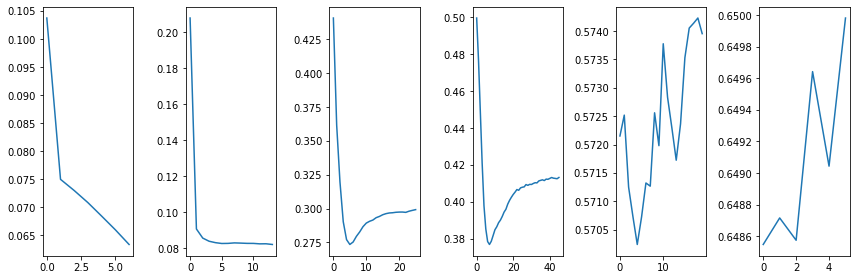

In [12]:
fig,ax = plt.subplots(nrows=1, ncols=6,figsize = (12, 4))

for index, axis in enumerate(ax.ravel()): 
    axis.plot(de_epoch_losses_models[index][0])
    #axis.plot(test_epoch_losses_models[index][0])
    #axis.plot(test_epoch_losses_models_float[index][0])
plt.tight_layout()

#### Harder regularisation

In [20]:
torch.cuda.empty_cache()


In [11]:
#train loop = 
#trained_models = []
train_epoch_losses_models_l10 = []
val_epoch_losses_models_l10 = []
latent_reps_models_l10 = []
test_epoch_losses_models_l10 = []
de_epoch_losses_models_l10 = []
epoch_total_losses_models_l10 = []
for k_index in range(SEQ_LEN):
    
    k_models = []
    k_train_losses = []
    k_val_losses = []
    k_latent_reps = []
    k_test_losses = []
    k_de_epoch_losses = []
    k_epoch_total_losses = []
    landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_index] 
    for replicate_index in range(1): 
        print('Training model for K={}, R={}'.format(k_index, replicate_index))
        model_instance = mlp_models[k_index][replicate_index]
        model_name = 'mlp'
        loss_fn   = nn.MSELoss()
        optimizer = optim.Adam(model_instance.parameters(), lr=0.001)
        train_dataloader = DataLoader(xy_train[replicate_index], batch_size=128, shuffle=True)
        val_dataloader   = DataLoader(xy_val[replicate_index], batch_size=128)
        x_test = x_tests[replicate_index]
        y_test = y_tests[replicate_index]
     
        _, train_epoch_losses, val_epoch_losses, test_epoch_losses, de_epoch_losses, epoch_latent_reps, epoch_total_losses = train_model_de_reg(model=model_instance, model_name=model_name,optimizer=optimizer,  loss_fn=loss_fn, train_loader=train_dataloader, 
                                                                                                val_loader=val_dataloader,
                                                                                               n_epochs=100, device='cuda', patience=10, 
                                                                                                min_delta=1e-5, x_data=landscapes_as_tensor[k_index][replicate_index], 
                                                                                               x_test=x_test, y_test=y_test, lambda_reg=5, batch_size=128, batch_frequency=30)
        k_train_losses.append(train_epoch_losses)
        k_val_losses.append(val_epoch_losses)
        k_latent_reps.append(epoch_latent_reps)
        k_test_losses.append(test_epoch_losses)
        k_de_epoch_losses.append(de_epoch_losses)
        k_epoch_total_losses.append(epoch_total_losses)
    train_epoch_losses_models_l10.append(k_train_losses)
    val_epoch_losses_models_l10.append(k_val_losses)
    latent_reps_models_l10.append(k_latent_reps)
    test_epoch_losses_models_l10.append(k_test_losses)
    de_epoch_losses_models_l10.append(k_de_epoch_losses)
    epoch_total_losses_models_l10.append(k_epoch_total_losses)

Training model for K=0, R=0
Epoch [1/100], Train Loss: 1.4130, Val Loss: 0.0056
Epoch [2/100], Train Loss: 0.0248, Val Loss: 0.0053
Epoch [3/100], Train Loss: 0.0133, Val Loss: 0.0051
Epoch [4/100], Train Loss: 0.0099, Val Loss: 0.0046
Epoch [5/100], Train Loss: 0.0078, Val Loss: 0.0038
Epoch [6/100], Train Loss: 0.0065, Val Loss: 0.0035
Epoch [7/100], Train Loss: 0.0056, Val Loss: 0.0033
Epoch [8/100], Train Loss: 0.0049, Val Loss: 0.0032
Epoch [9/100], Train Loss: 0.0040, Val Loss: 0.0031
Epoch [10/100], Train Loss: 0.0034, Val Loss: 0.0029
Epoch [11/100], Train Loss: 0.0030, Val Loss: 0.0028
Epoch [12/100], Train Loss: 0.0027, Val Loss: 0.0028
Epoch [13/100], Train Loss: 0.0024, Val Loss: 0.0026
Epoch [14/100], Train Loss: 0.0020, Val Loss: 0.0026
Epoch [15/100], Train Loss: 0.0017, Val Loss: 0.0026
Epoch [16/100], Train Loss: 0.0018, Val Loss: 0.0025
Epoch [17/100], Train Loss: 0.0018, Val Loss: 0.0024
Epoch [18/100], Train Loss: 0.0019, Val Loss: 0.0024
Epoch [19/100], Train Loss:

/tmp/ipykernel_12373/2343163564.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


Epoch [1/100], Train Loss: 2.6849, Val Loss: 0.0094
Epoch [2/100], Train Loss: 0.1135, Val Loss: 0.0074
Epoch [3/100], Train Loss: 0.0614, Val Loss: 0.0072
Epoch [4/100], Train Loss: 0.0449, Val Loss: 0.0070
Epoch [5/100], Train Loss: 0.0355, Val Loss: 0.0068
Epoch [6/100], Train Loss: 0.0295, Val Loss: 0.0068
Epoch [7/100], Train Loss: 0.0242, Val Loss: 0.0066
Epoch [8/100], Train Loss: 0.0209, Val Loss: 0.0066
Epoch [9/100], Train Loss: 0.0177, Val Loss: 0.0065
Epoch [10/100], Train Loss: 0.0148, Val Loss: 0.0064
Epoch [11/100], Train Loss: 0.0141, Val Loss: 0.0064
Epoch [12/100], Train Loss: 0.0123, Val Loss: 0.0064
Epoch [13/100], Train Loss: 0.0118, Val Loss: 0.0064
Epoch [14/100], Train Loss: 0.0107, Val Loss: 0.0063
Epoch [15/100], Train Loss: 0.0105, Val Loss: 0.0063
Epoch [16/100], Train Loss: 0.0101, Val Loss: 0.0063
Epoch [17/100], Train Loss: 0.0101, Val Loss: 0.0062
Epoch [18/100], Train Loss: 0.0095, Val Loss: 0.0061
Epoch [19/100], Train Loss: 0.0085, Val Loss: 0.0061
Ep

In [18]:
val_epoch_losses_models_l10_flt = [[[i.item() for i in j] for j in k] for k in val_epoch_losses_models_l10]

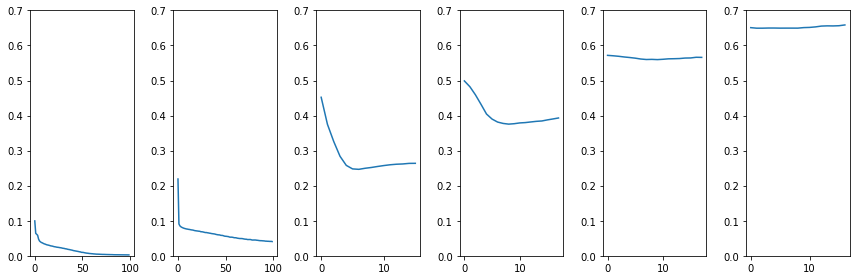

In [23]:
fig,ax = plt.subplots(nrows=1, ncols=6,figsize = (12, 4))

for index, axis in enumerate(ax.ravel()): 
    axis.plot(de_epoch_losses_models_l10[index][0])
    #axis.plot(val_epoch_losses_models_l10_flt[index][0])
    axis.set_ylim(0, 0.7)
    #axis.plot(test_epoch_losses_models[index][0])
    #axis.plot(test_epoch_losses_models_float[index][0])
plt.tight_layout()

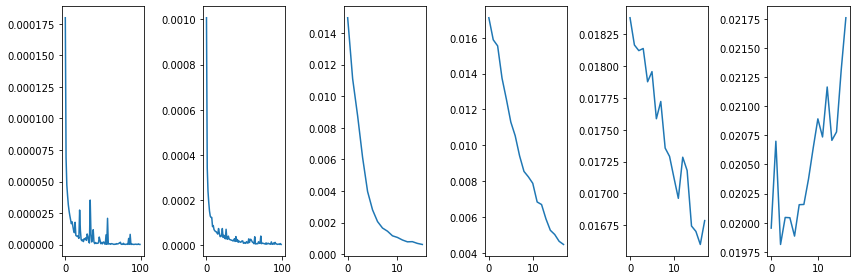

In [22]:
fig,ax = plt.subplots(nrows=1, ncols=6,figsize = (12, 4))

for index, axis in enumerate(ax.ravel()): 
    #axis.plot(de_epoch_losses_models_l10[index][0])
    axis.plot(test_epoch_losses_models_l10[index][0])
    #axis.set_ylim(0, 0.7)
    #axis.plot(test_epoch_losses_models[index][0])
    #axis.plot(test_epoch_losses_models_float[index][0])
plt.tight_layout()

In [38]:
epoch_dirichlets = []

for k_ind in range(SEQ_LEN): 
    k_results = []
    for r_ind in range(1):
        t1 = time.time()
        print('Working on K:{}, R:{}'.format(k_ind, r_ind))
        latent_dirichlets = np.array([dirichlet_from_representation(latent_reps_models[k_ind][r_ind][i], landscapes_y[k_ind][r_ind]) 
                               for i in range(len(latent_reps_models[k_ind][r_ind]))])
        k_results.append(latent_dirichlets)
        t2 = time.time()
        print('Took {} sec'.format(t2-t1))
    epoch_dirichlets.append(k_results)
        


Working on K:0, R:0
Took 29.299577236175537 sec
Working on K:1, R:0
Took 53.08699655532837 sec
Working on K:2, R:0
Took 43.81811046600342 sec
Working on K:3, R:0
Took 81.74528551101685 sec
Working on K:4, R:0
Took 30.08561086654663 sec
Working on K:5, R:0
Took 11.315135717391968 sec


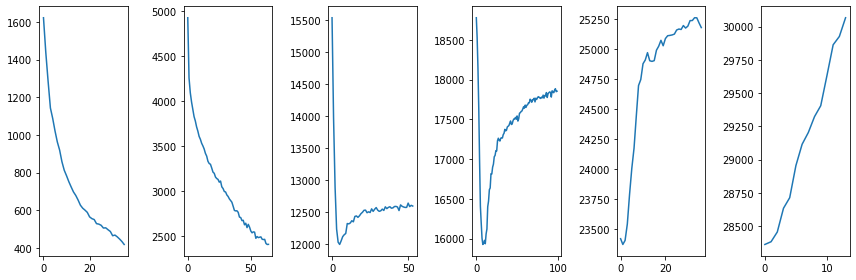

In [41]:
fig,ax = plt.subplots(nrows=1, ncols=6,figsize = (12, 4))

for index, axis in enumerate(ax.ravel()): 
    axis.plot(epoch_dirichlets[index][0])
plt.tight_layout()